In [24]:
import os
import sys
import pickle
import shutil
import multiprocessing as mp
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchgeo.datasets import NonGeoDataset, stack_samples, unbind_samples
from torchgeo.datamodules import NonGeoDataModule
from torchgeo.trainers import PixelwiseRegressionTask, SemanticSegmentationTask
from torchvision.transforms.functional import pad
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import WandbLogger
import geopandas as gpd
import rasterio
import numpy as np
from sklearn.model_selection import train_test_split

sys.path.append("/n/home07/kayan/scripts/")
from asm_train_test_split import split_asm_data

## Toy Dataset Creation

Create a toy dataset composed of a subset of 100 images, so that experimenting with torchgeo is easier

In [2]:
root = "/n/holyscratch01/tambe_lab/kayan/karena/"

In [4]:
def copy_first_n_files(source_dir, destination_dir, n):
    # Get the list of unique ids
    path="/n/home07/kayan/data/filtered_labels.geojson"
    label_df = gpd.read_file(path)
    ids = label_df.head(n)["unique_id"].values
    file_nms = [f"{unique_id}.tif" for unique_id in ids]

    # Ensure destination directory exists, create if not
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    # Copy the first n files
    for file_nm in file_nms:
        source_path = os.path.join(source_dir, file_nm)
        destination_path = os.path.join(destination_dir, file_nm)
        shutil.copy2(source_path, destination_path)
        
destination = "/n/home07/kayan/data/"
n = 100
copy_first_n_files(root+"images/", destination+"images/", n)
copy_first_n_files(root+"rasters/", destination+"rasters/", n)

## Create Torchgeo Datasets

In [94]:
def min_max_transform(sample, target_size=(256,256)):
    img = sample["image"].permute(1, 2, 0) # moves spectral channels to final dimension
    mask = sample["mask"]
    
    # min-max scaling
    img = img.numpy()
    img_norm = (img - np.min(img,axis=(0,1))) / (np.max(img,axis=(0,1)) - np.min(img,axis=(0,1))) 
    
    img_norm = torch.tensor(img_norm).permute(2, 0, 1) # re-permute spectral channels to first dimension
    
    # pad data to be 256x256
    img_norm = [
            pad(channel, padding=(0,0,target_size[1] - channel.shape[1], target_size[0] - channel.shape[0]), fill=0)
            for channel in img_norm
        ]
    img_norm = torch.stack(img_norm, dim=0)
    mask = pad(mask, padding=(0,0,target_size[1] - mask.shape[1], target_size[0] - mask.shape[0]), fill=0)
    
    sample["image"] = img_norm
    sample["mask"] = mask
    return sample

In [95]:
class ASMDataset(NonGeoDataset):
    splits = ["train", "val", "test"]
    all_bands = ["B", "G", "R", "NIR", "Mask"]
    rgb_bands = ["R", "G", "B"]
    
    def __init__(
        self,
        root = "/n/home07/kayan/data/",
        transforms = None,
        split = "train",
        bands = ["R", "G", "B", "NIR"],
        split_path = "/n/home07/kayan/data/train_test_split"
    ) -> None:
        """Initialize a new ASMData instance.

        Args:
            root: root directory where dataset can be found
            transforms: a function/transform that takes input sample and its target as
                entry and returns a transformed version
            split: one of "train," "val", or "test"
            bands: the subset of bands to load
            split_path: path to file containing unique identifiers for train/test/val split, generated with scripts/train_test_split.py
        """  
        self.root = root
        self.transforms = transforms
        assert split in ["train", "val", "test"]
        self.bands = bands
        self.band_indices = [self.all_bands.index(b) + 1 for b in bands if b in self.all_bands] # add 1 since rasterio starts index at 1, not 0
        
        # get unique identifiers of desired split
        with open(split_path,'rb') as handle:
            split_data = pickle.load(handle)
        self.ids = split_data[split]
        
        # convert unique identifiers to file names
        self.image_filenames = [f"{self.root}images/{unique_id}.tif" for unique_id in self.ids]
        self.mask_filenames = [f"{self.root}rasters/{unique_id}.tif" for unique_id in self.ids]
        
    def __len__(self):
        """Return the number of chips in the dataset.

        Returns:
            length of the dataset
        """
        return len(self.image_filenames)
        
    def __getitem__(self, index: int):
        """Return item at an index within the dataset.

        Args:
            index: index to return

        Returns:
            a dict containing image, mask, transform, crs, and metadata at index.
        """
        img_fn = self.image_filenames[index]
        mask_fn = self.mask_filenames[index]
        
        img = rasterio.open(img_fn).read(self.band_indices)
        img = torch.from_numpy(np.array(img, dtype=np.float32))
        
        mask = rasterio.open(mask_fn).read(1)
        mask = torch.from_numpy(np.array(mask, dtype=np.float32))
        
        sample = {"image": img, "mask": mask}

        if self.transforms is not None:
            sample = self.transforms(sample)

        return sample
    
    def plot(self, sample):
        # Find the correct band index order
        rgb_indices = []
        for band in self.rgb_bands:
            rgb_indices.append(self.bands.index(band))

        # Reorder and rescale the image
        image = sample["image"][rgb_indices].permute(1, 2, 0)
        image = image.numpy()
        # min-max scaling
        image_norm = (image - np.min(image,axis=(0,1))) / (np.max(image,axis=(0,1)) - np.min(image,axis=(0,1))) 
        
        # Reorder mask
        mask = sample["mask"]

        # Plot the image
        fig, axs = plt.subplots(ncols=2)
        axs[0].imshow(image_norm)
        axs[1].imshow(mask,cmap="gray")

        return fig

In [96]:
root = "/n/home07/kayan/data/"

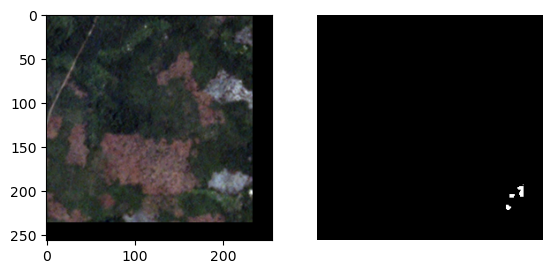

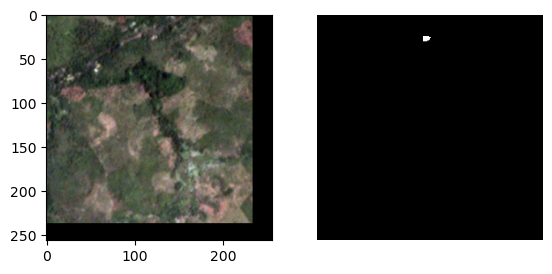

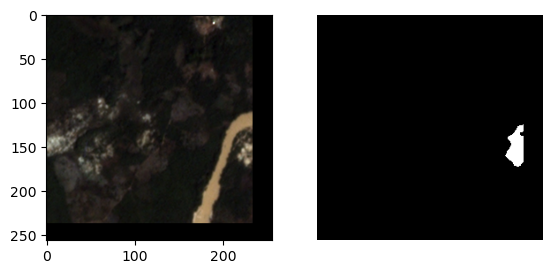

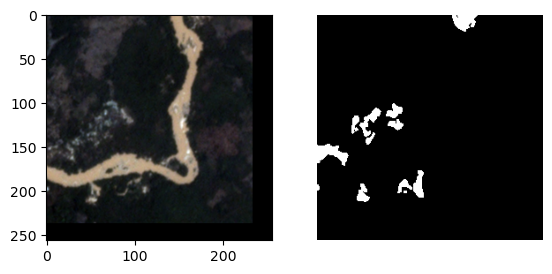

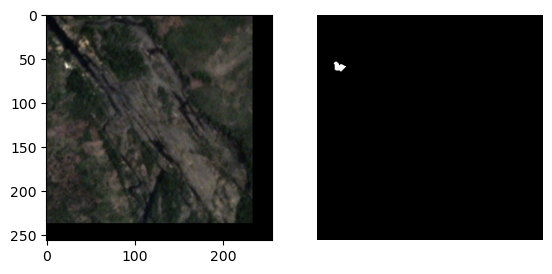

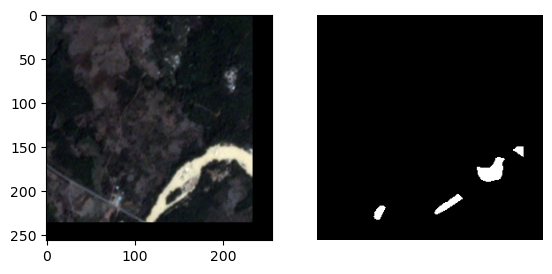

In [105]:
torch.manual_seed(1)
dataset = ASMDataset(root,bands=["B","G","R","NIR"],transforms=min_max_transform,split="val")

dataloader = DataLoader(dataset, batch_size=3, shuffle=True)

for batch in dataloader:
    sample = unbind_samples(batch)[0]
    dataset.plot(sample)
    plt.axis("off")
    plt.show()

## Create datamodule

In [98]:
class ASMDataModule(NonGeoDataModule):
    def __init__(
        self, 
        batch_size: int = 8, 
        num_workers: int = 1,
        split: bool = False,
        split_n: int = None,
        **kwargs
    ) -> None:
        """Initialize a new ASMModule instance.

        Args:
            batch_size: Size of each mini-batch.
            num_workers: Number of workers for parallel data loading.
            split: Whether or not to perform a new train-test-val split of data.
            split_n: Number of tiles to include in train-test-val split
            **kwargs: Additional keyword arguments passed to ASMDataset.
        """
        # perform train-test-val split and pass path to output file as kwarg to ASMDataset
        if split:
            split_path = split_asm_data(n=split_n)
            kwargs["split_path"] = split_path
        super().__init__(ASMDataset, batch_size, num_workers, **kwargs)

In [99]:
root = root = "/n/home07/kayan/data/"
datamodule = ASMDataModule(split=True, split_n=100, root=root, transforms=min_max_transform)

Split with 64 train images, 16 validation images, and 20 test images
Mine proportions
 Train: 1.0
 Validation: 1.0
 Test: 1.0


## Create prediction task

In [100]:
task = SemanticSegmentationTask(
    model="unet",
    backbone="resnet18",
    weights=True,
    loss="focal",
    in_channels=4,
    num_classes=2,
    lr=1e-3,
    patience=5,
    freeze_backbone=True,
    freeze_decoder=False
)

In [101]:
DEVICE, NUM_DEVICES = ("cuda", torch.cuda.device_count()) if torch.cuda.is_available() else ("cpu", mp.cpu_count())
WORKERS = mp.cpu_count()
print(f'Running on {NUM_DEVICES} {DEVICE}(s)')

Running on 1 cuda(s)


In [102]:
wandb_logger = WandbLogger(project="0_ASM_seg", log_model="all")
checkpoint_callback = ModelCheckpoint(monitor="val_loss",every_n_epochs=1)

In [103]:
trainer = Trainer(
        accelerator=DEVICE,
        devices=NUM_DEVICES,
        max_epochs=15,
        callbacks=[checkpoint_callback],
        logger=wandb_logger,
    )

/n/home07/kayan/miniconda3/envs/geo-ml/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /n/home07/kayan/miniconda3/envs/geo-ml/lib/python3.1 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [104]:
trainer.fit(model=task, datamodule=datamodule)

/n/home07/kayan/miniconda3/envs/geo-ml/lib/python3.11/site-packages/lightning/pytorch/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | FocalLoss        | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | Unet             | 14.3 M
---------------------------------------------------
3.2 M     Trainable params
11.2 M    Non-trainable params
14.3 M    Total params
57.326    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/n/home07/kayan/miniconda3/envs/geo-ml/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/n/home07/kayan/miniconda3/envs/geo-ml/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/n/home07/kayan/miniconda3/envs/geo-ml/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
